In [119]:
import dolfin as dolf
from math import pi
import params
import numpy as np
from slepc4py import SLEPc

In [120]:
N = 10
size_M = (N+1)*2

In [121]:
def print_blockform(C):
    C = C.getValues(range(size_M), range(size_M))
    K = np.zeros_like(C)
    for i in range(N+1):
        for j in range(N+1):
            C_ij = C[2*i:2*i+2,2*j:2*j+2]
            K[i, j] = C_ij[0, 0]
            K[i, j+N+1] = C_ij[0, 1]
            K[i+N+1, j] = C_ij[1, 0]
            K[i+N+1, j+N+1] = C_ij[1, 1]
    return K

Now we define the mesh;

The definition of the subdomain and left and right boundaries will be changed.


In [122]:
def mshr(el):

    mesh = dolf.UnitIntervalMesh(el)

    def l_boundary_func(x, on_boundary):
        x = x[0]
        return on_boundary and dolf.near(x, 0.)

    def r_boundary_func(x, on_boundary):
        x = x[0]
        return on_boundary and dolf.near(x, 1.)

    boundaries = dolf.MeshFunction('size_t', mesh, mesh.topology().dim() - 1)

    l_boundary = dolf.AutoSubDomain(l_boundary_func)
    r_boundary = dolf.AutoSubDomain(r_boundary_func)

    l_boundary.mark(boundaries, 1)
    r_boundary.mark(boundaries, 2)

    # ________________________________________________________________________________

    def fl_subdomain_func(x):
        x = x[0]
        x_f = params.x_f[0][0]
        a_f = params.a_f
        return x_f - a_f - dolf.DOLFIN_EPS <= x <= x_f + a_f + dolf.DOLFIN_EPS

    subdomains = dolf.MeshFunction('size_t', mesh, mesh.topology().dim())

    subdomains.set_all(1)

    fl_subdomain = dolf.AutoSubDomain(fl_subdomain_func)
    fl_subdomain.mark(subdomains, 0)

    return mesh, boundaries, subdomains

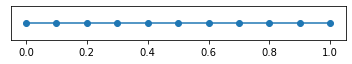

In [123]:
mesh, boundaries, subdomains = mshr(N)
dolf.plot(mesh)

In [124]:
boundary_conditions = {1: {'Robin': params.Y_in},  # inlet
                           2: {'Robin': params.Y_out}}  # outlet

In [125]:
degree = 1
c = params.c
constrained_domain=None

Now we will do Passive Flame Case Calculations;

In [126]:
dx = dolf.Measure('dx', domain=mesh)
ds = dolf.Measure('ds', domain=mesh, subdomain_data=boundaries)

CG = dolf.FiniteElement('CG', mesh.ufl_cell(), degree)
W = dolf.FunctionSpace(mesh, CG * CG, constrained_domain=constrained_domain)

function_space = W  #
u = dolf.TrialFunction(W)
v = dolf.TestFunction(W)

bcs = []

for i in boundary_conditions:
    if 'Dirichlet' in boundary_conditions[i]:
        for j in range(2):
            bc = dolf.DirichletBC(W.sub(j), 0.0, boundaries, i)
            bcs.append(bc)

## MATRIX A AND ITS ASSEMBLY

In [127]:
(u_1, u_2) = u
(v_1, v_2) = v

a_11 = - c ** 2 * dolf.dot(dolf.grad(v_1), dolf.grad(u_1)) * dx
a_22 = - c ** 2 * dolf.dot(dolf.grad(v_2), dolf.grad(u_2)) * dx
a_ = a_11 + a_22

dummy = (v_1 + v_2) * dx

A, b = dolf.assemble_system(a_, dummy, bcs)
A = dolf.as_backend_type(A).mat()
print_blockform(A)

array([[-14.35294118,  14.35294118,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ 14.35294118, -28.70588235,  14.35294118,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  14.35294118, -28.70588235,  14.35294118,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.    

## MATRIX B AND ITS ASSEMBLY

In [128]:
(u_1, u_2) = u
(v_1, v_2) = v

N = function_space.dim()  # global size
istart, iend = function_space.dofmap().ownership_range()
n = iend - istart  # local size
print(N,n)

22 22


In [129]:
integrals_R = []

for i in boundary_conditions:
    if 'Robin' in boundary_conditions[i]:

        Y = boundary_conditions[i]['Robin']
        Y_r, Y_i = Y.real, Y.imag

        b_11 = - Y_i * c * v_1 * u_1 * ds(i)
        b_12 = - Y_r * c * v_1 * u_2 * ds(i)
        b_21 = + Y_r * c * v_2 * u_1 * ds(i)
        b_22 = - Y_i * c * v_2 * u_2 * ds(i)

        b_ = b_11 + b_12 + b_21 + b_22

        integrals_R.append(b_)

if integrals_R:

    b_ = sum(integrals_R)
    B = dolf.assemble(b_)
    B = dolf.as_backend_type(B).mat()

else:

    B = PETSc.Mat().create()
    B.setSizes([(n, N), (n, N)])
    B.setFromOptions()
    B.setUp()
    B.assemble()

B.getValues(range(size_M), range(size_M))

array([[-38.33720356, -17.97056417,  -0.        ,  -0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ 17.97056417, -38.33720356,   0.        ,  -0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ -0.        ,  -0.        ,  -0.        ,  -0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.    

## ASSEMBLY OF C

In [130]:
(u_1, u_2) = u
(v_1, v_2) = v

c_11 = v_1 * u_1 * dx
c_22 = v_2 * u_2 * dx
c_   = c_11 + c_22

dummy = (v_1 + v_2) * dx

C, b = dolf.assemble_system(c_, dummy, bcs)
[bc.zero(C) for bc in bcs]
C = dolf.as_backend_type(C).mat()
C.getValues(range(size_M), range(size_M))

array([[0.03333333, 0.        , 0.01666667, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.03333333, 0.        , 0.01666667, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.01666667, 0.        , 0.06666667, 0.        , 0.01666667,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.01666667, 0.        , 0.06666667, 0.        ,
        0.0166666

## PEP SOLVER

In [131]:
target = np.pi
nev = 1

In [132]:
E = SLEPc.PEP().create()

operators = [A, B, C]
E.setOperators(operators)

# Q.setProblemType(SLEPc.PEP.ProblemType.GENERAL)

# spectral transformation
st = E.getST()
st.setType('sinvert')

E.setTarget(target)
E.setWhichEigenpairs(SLEPc.PEP.Which.TARGET_MAGNITUDE)  # TARGET_REAL or TARGET_IMAGINARY

E.setDimensions(nev, SLEPc.DECIDE)
E.setTolerances(1e-15)
E.setFromOptions()

E.solve()

## NORMALIZATION OF EIGENVECTORS

In [133]:

omega = 0.
A = E.getOperators()[0]
vr, vi = A.createVecs()

eig = E.getEigenpair(1, vr, vi)
omega = eig
omega


(3.4232953882657817-0.026894463503111303j)

In [134]:
V = dolf.FunctionSpace(mesh, "CG", degree, constrained_domain=constrained_domain)
CG = dolf.FiniteElement("CG", mesh.ufl_cell(), degree)
W = dolf.FunctionSpace(mesh, dolf.MixedElement([CG, CG]), constrained_domain=constrained_domain)

vr_1 = vr.getArray()[0::2]
vr_2 = vr.getArray()[1::2]
vi_1 = vi.getArray()[0::2]
vi_2 = vi.getArray()[1::2]

x = vr_1 - vi_2 + 1j * (vr_2 + vi_1)

x_r = x.real
x_i = x.imag

p_r = dolf.Function(V)
p_i = dolf.Function(V)

p_r.vector().set_local(x_r)
p_r.vector().apply('insert')
p_i.vector().set_local(x_i)
p_i.vector().apply('insert')

dx = dolf.Measure('dx')
meas = dolf.assemble((p_r * p_r + p_i * p_i) * dx)
meas = np.sqrt(meas)
# print(meas)

x /= meas

x_r = x.real
x_i = x.imag

# p_r.vector().set_local(x_r)
# p_r.vector().apply('insert')
# p_i.vector().set_local(x_i)
# p_i.vector().apply('insert')
#
# meas = dolf.assemble((p_r * p_r + p_i * p_i) * dx)
# meas = np.sqrt(meas)
# # print(meas)

x = vr.copy()

istart, iend = x.getOwnershipRange()

x[istart:iend:2] = x_r
x[istart+1:iend+1:2] = x_i

p = dolf.Function(W)
p.vector().set_local(x.getArray())
p.vector().apply('insert')

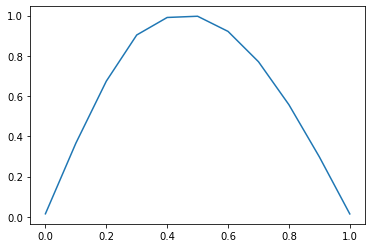

In [135]:
p_r, p_i = p.split(True)
dolf.plot(p_r)

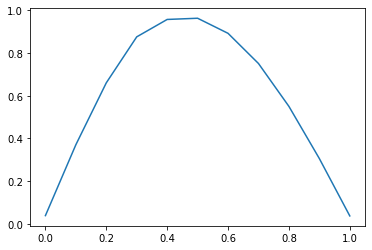

In [136]:
dolf.plot(p_i)